In [33]:
import scanpy as sc
import numpy as np
import random
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)

data_path = "E:/GEO/snRNA-seq/"
sample_IDs = ["OpossumV1-3A", "OpossumV1-3B", "OpossumV1-4A", "OpossumV1-4B"]

adatas = []
for sid in sample_IDs:
    temp_adata = sc.read_10x_mtx(data_path + sid)
    adatas.append(temp_adata)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [50]:
adatas[0].var_names

Index(['ENSMODG00000016695', 'ENSMODG00000034911', 'ENSMODG00000027996',
       'ENSMODG00000032478', 'GLRX3', 'ENSMODG00000043448',
       'ENSMODG00000036380', 'ENSMODG00000046419', 'ENSMODG00000051545',
       'ENSMODG00000043160',
       ...
       'ENSMODG00000011746', 'TMEM35A', 'ENSMODG00000031334', 'XKRX', 'CSTF2',
       'ENSMODG00000011798', 'SYTL4', 'ENSMODG00000038201', 'SRPX2',
       'ENSMODG00000011865'],
      dtype='object', length=30800)

In [51]:
import pandas as pd
import anndata as ad

# Put opossum genes in ortholog space immediately
def update_anndata_genes_by_mapping(adata: ad.AnnData, mapping_path: str) -> ad.AnnData:
    """
    Replace gene names in an AnnData object using a mapping file, 
    excluding genes with duplicated stable IDs (e.g., paralogs).
    
    Parameters
    ----------
    adata : AnnData
        An AnnData object with genes as .var_names.
    mapping_path : str
        Path to a TXT file with gene mapping from Ensembl BioMart. Expected format:
        - Column 0: Gene name mapped from (Opossum, if it exists)
        - Column 1: Ensembl ID (Opossum, if gene has no name)
        - Column 2: Gene name mapped to (Mouse, in this case)
        - Column 3: Ensembl ID (Mouse, if gene has no name)
    
    Returns
    -------
    AnnData
        Modified AnnData object with updated .var_names.
    """
    genes_mapping = pd.read_csv(mapping_path)
    
    # Identify non-empty duplicated Gene.stable.IDs (e.g., paralogs)
    gene_stable_ids = genes_mapping.iloc[:, 0]
    non_empty = gene_stable_ids.isnull() == False
    duplicated = gene_stable_ids.duplicated(keep=False)
    exclude = non_empty & duplicated

    # Filter out non-empty duplicated Gene.stable.IDs
    genes_mapping = genes_mapping[~exclude].copy()
    
    # Extract columns
    genes_mapping_self = genes_mapping.iloc[:, 0].tolist()  # Gene.stable.ID
    ids_mapping_self = genes_mapping.iloc[:, 1].tolist()    # Current ID (used in var_names)
    genes_mapping_other = genes_mapping.iloc[:, 2].tolist() # New name to assign

    # Work with a copy of var_names
    var_names = adata.var_names.to_list()

    for i, gene in enumerate(genes_mapping_other):
        idx_other = [j for j, x in enumerate(genes_mapping_other) if x == gene]
        
        if len(idx_other) == 1:
            idx = idx_other[0]
            gene_self = genes_mapping_self[idx]
            id_self = ids_mapping_self[idx]
            
            if isinstance(gene_self, str) == False:
                if id_self in var_names:
                    idx_self = var_names.index(id_self)
                    var_names[idx_self] = gene
            else:
                if gene_self in var_names:
                    idx_self = var_names.index(gene_self)
                    var_names[idx_self] = gene

    adata.var_names = pd.Index(var_names)
    return adata

# Modify in place
mapping_path = "../data/Opossum_Mouse_GeneMapping_EnsemblBioMart.txt"
for i in range(len(adatas)):
    adatas[i] = update_anndata_genes_by_mapping(adatas[i], mapping_path)

In [52]:
adatas[0].var_names

Index(['Ebf3', 'ENSMODG00000034911', 'ENSMODG00000027996',
       'ENSMODG00000032478', 'Glrx3', 'ENSMODG00000043448',
       'ENSMODG00000036380', 'ENSMODG00000046419', 'ENSMODG00000051545',
       'ENSMODG00000043160',
       ...
       'Cenpi', 'Tmem35a', 'ENSMODG00000031334', 'Xkrx', 'Cstf2',
       'ENSMODG00000011798', 'Sytl4', 'Thap2', 'Srpx2', 'Tspan6'],
      dtype='object', length=30800)

In [58]:
adatas[3].obs

""
AAACCCAAGGGAACAA-1
AAACCCAAGGGCAAGG-1
AAACCCAAGTTCTACG-1
AAACCCACAAGATTGA-1
AAACCCACACAATTCG-1
...
TTTGTTGCATTGGATC-1
TTTGTTGGTCACTGAT-1
TTTGTTGGTCCATCTC-1
TTTGTTGGTCTGCGCA-1


In [ ]:
# Add metadata and subset to curated, final cell populations (for one iteration of analysis; file called _All_Labeled.h5ad)
for i, sid in enumerate(sample_IDs):
    meta = pd.read_csv(data_path + sid + "/metadata.tsv.gz", sep="\t")
    adatas[i].obs = meta
    adatas[i] = adatas[i][adatas[i].obs["subclass"].isnull() == False, :].copy()

In [63]:
adata_all = ad.concat(adatas)

In [64]:
# Store the counts
adata_all.layers["counts"] = adata_all.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata_all)
# Logarithmize the data
sc.pp.log1p(adata_all)
# Select highly variable genes
sc.pp.highly_variable_genes(adata_all)
# Compute PCA
sc.tl.pca(adata_all)
# Find neighbors
sc.pp.neighbors(adata_all)
# Run UMAP
sc.tl.umap(adata_all)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:42)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


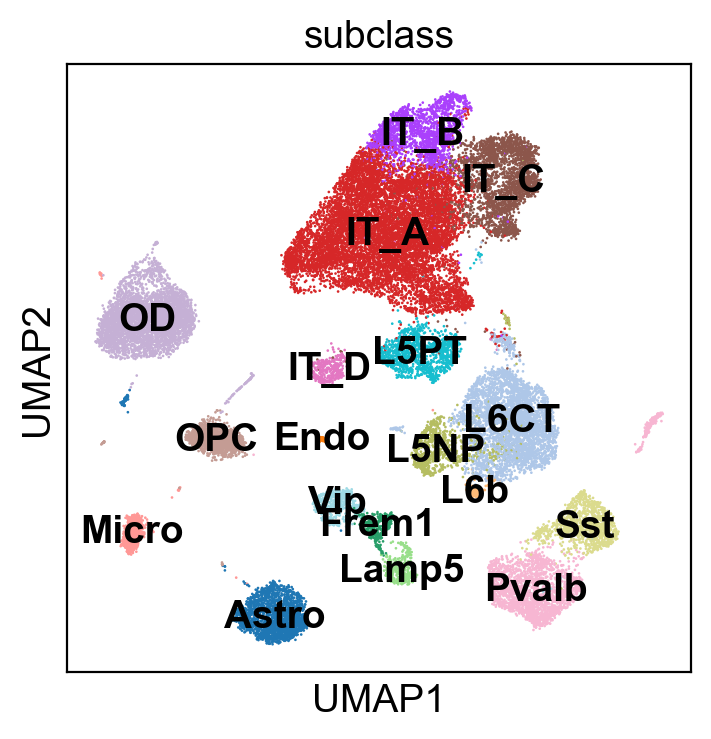

In [65]:
sc.pl.umap(adata_all, color=["subclass"], legend_loc="on data")

In [69]:
adata_all.obs["predicted_doublets"] = adata_all.obs["predicted_doublets"].astype(bool)
adata_all.write_h5ad("E:/Ryan/GitHub/scGPT-cross/data/Opossum_V1_All_Labeled.h5ad")